### Artificial Neural Network
***Taha Adeel Mohammed - CS20BTECH11052***

Below Python code implements a generic Artificial Neural Network (ANN) with variable number of hidden layers and neurons in each layer. The code is very modular, and can be used on various supervised datasets.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple, List

np.set_printoptions(suppress=True, precision=5)
np.random.seed(0)

In [2]:
# Activation functions
def identity(x: np.ndarray, derivative: bool = False) -> np.ndarray:
    if derivative:
        return np.ones_like(x)
    return x
    
def sigmoid(x: np.ndarray, derivative: bool = False) -> np.ndarray:
    if derivative:
        return sigmoid(x) * (1 - sigmoid(x))
    return 1 / (1 + np.exp(-x))

def ReLU(x: np.ndarray, derivative: bool = False) -> np.ndarray:
    if derivative:
        return np.where(x > 0, 1, 0)
    return np.where(x > 0, x, 0)

def tanh(x: np.ndarray, derivative: bool = False) -> np.ndarray:
    if derivative:
        return 1 - tanh(x)**2
    return np.tanh(x)

def softmax(x: np.ndarray, derivative: bool = False) -> np.ndarray:
    if derivative:
        return softmax(x) * (1 - softmax(x))
    exps = np.exp(x - x.max())
    return exps / np.sum(exps, axis=1, keepdims=True)

# Loss functions
def squared_error_loss(y_true: np.ndarray, y_pred: np.ndarray, derivative: bool = False) -> float | np.ndarray:
    if derivative:
        return 2 * (y_pred - y_true)
    return np.mean(np.sum((y_pred - y_true)**2, axis=1))

#### Layer Class

In [3]:
class Layer:
    '''
    Creates a layer of the neural network.
    '''
    
    def __init__(self, 
                 n_inputs: int, 
                 n_neurons: int, 
                 activation: Callable = sigmoid,
                 weights: np.ndarray | None = None,
                 bias: bool = True):
        '''
        Initializes the layer with the given number of inputs(P) and neurons(M).
        '''
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        self.activation = activation
        self.bias = bias
        self.input = None
        self.preactivation_output = None
        self.output = None
        self.weights = None
        self.weights_delta = None
        
        if self.bias:
            self.n_inputs += 1 # Add bias node
            
        # Initialize weights
        if weights is None:
            self.weights = np.random.rand(self.n_inputs, self.n_neurons) - 0.5 # Normally distributed random weights
        else:
            self.weights = weights
        self.weights_delta = np.zeros_like(self.weights)
    
    def forward_propagation(self, input: np.ndarray) -> np.ndarray:
        '''Forward propagation of input through the layer'''
        if self.bias:
            input = np.c_[np.ones((input.shape[0], 1)), input] # Concatenate 1s to input for bias
        self.input = input
        self.preactivation_output = input @ self.weights
        self.output = self.activation(self.preactivation_output)
        return self.output
    
    def backward_propagation(self, output_error: np.ndarray) -> np.ndarray:
        '''Computes dE/d_input for a given dE/d_output, and caches the weight updates to be done for this sample input'''
        output_error = output_error * self.activation(self.preactivation_output, derivative=True)
        
        # Update delta weights
        weights_delta = self.input.T @ output_error
        self.weights_delta += weights_delta
        
        # Compute input error
        input_error = output_error @ self.weights.T[:, (1 if self.bias else 0):]
        return input_error
    
    def update_weights(self, learning_rate: float) -> None:
        '''Updates the weights of the layer'''
        self.weights -= learning_rate * self.weights_delta
        self.weights_delta = np.zeros_like(self.weights)
        
    def __str__(self) -> str:
        return f'Layer(n_inputs={self.n_inputs}, n_neurons={self.n_neurons}, activation={self.activation.__name__}, bias={self.bias}) \n\tWeights:\n{self.weights}'

#### ANN Class

In [4]:
class ANN:
    ''' 
    Creates an Artificial Neural Network to learn from data.
    '''  
    def __init__(self, 
                    layers_nodes: list[int],
                    layers_activations: list[Callable] | None = None,
                    layer_weights: list[np.ndarray] | list[None] | None = None,
                    gk: Callable = identity,
                    bias: bool = True,
                    loss: Callable = squared_error_loss):
        '''
        Initializes the ANN with the given layers and learning rate.
        '''
        self.layers_nodes = layers_nodes
        self.gk = gk
        self.loss_fn = loss
        self.training_losses = []
        self.testing_losses = []
        self.training_accuracies = []
        self.testing_accuracies = []
        
        # Initialize layers
        self.layers = []
        if layers_activations is None:
            layers_activations = [sigmoid] * (len(layers_nodes) - 2)
            layers_activations.append(gk)
        if layer_weights is None:
            layer_weights = [None] * (len(layers_nodes) - 1)
        for i in range(1, len(layers_nodes)):
            self.layers.append(Layer(layers_nodes[i-1], layers_nodes[i], activation=layers_activations[i-1], bias=bias, weights=layer_weights[i-1]))
        
    def forward_propagation(self, input: np.ndarray) -> np.ndarray:
        '''Forward propagation of input through the network'''
        for layer in self.layers:
            input = layer.forward_propagation(input)
        self.output = input
        return self.output
    
    def backward_propagation(self, error: np.ndarray) -> None:
        '''Backward propagation of error through the network, updating the batch error in weigths'''
        for layer in reversed(self.layers):
            error = layer.backward_propagation(error)
    
    def train_SGD(self,
                    X_train: np.ndarray,
                    Y_train: np.ndarray,
                    X_test: np.ndarray,
                    Y_test: np.ndarray,
                    learning_rate: float = 0.01,
                    batch_size: int = 1,
                    max_epochs: int = 1000,
                    convergence_threshold: float = 1e-8,
                    accuracy_threshold: float = 0.5,
                    min_epochs: int = 100,
                    verbose: int = 0,
                    losses: bool = False) -> None:
        '''Trains the network on the given data using Stochastic Gradient Descent'''
        n_samples = X_train.shape[0]
        self.training_losses, self.testing_losses = [], []
        self.training_accuracies, self.testing_accuracies = [], []
        
        # Train using SGD
        for iteration in range(max_epochs):
            # Randomly select batch_size samples from the training data
            batch_indices = np.random.choice(n_samples, batch_size, replace=False)
            X_batch, Y_batch = X_train[batch_indices], Y_train[batch_indices]
            
            # Run forward and backward propagation on the batch
            for xi, yi in zip(X_batch, Y_batch):
                self.forward_propagation(xi.reshape(1, -1))
                error = self.loss_fn(yi, self.output, derivative=True)
                self.backward_propagation(error)
                
            # Update weights
            for layer in self.layers:
                layer.update_weights(learning_rate)
            
            if losses and iteration % 200 == 0:
                # Compute training and testing losses and accuracies
                self.training_losses.append(self.loss_fn(Y_train, self.predict(X_train)))
                self.testing_losses.append(self.loss_fn(Y_test, self.predict(X_test)))
                self.training_accuracies.append(self.get_accuracy(X_train, Y_train, threshold=accuracy_threshold))
                self.testing_accuracies.append(self.get_accuracy(X_test, Y_test, threshold=accuracy_threshold))
                
            
            # Print progress
            if verbose > 0 and losses and iteration % 200 == 0:
                print(f'Epoch: {iteration+1} | Training Loss: {self.training_losses[-1]} | Testing Loss: {self.testing_losses[-1]} | Training Accuracy: {self.training_accuracies[-1]} | Testing Accuracy: {self.testing_accuracies[-1]}')
                
            if verbose > 1 and iteration % 200 == 0:
                X_plot = np.array(sorted(X_train))
                Y_plot = self.predict(X_plot)
                plt.plot(X_plot, Y_plot, label=f'Epoch {iteration}')
            if verbose > 10:
                self.display_outputs()
                print(self)
                
            # Check for convergence
            # if iteration > min_epochs and (np.abs(self.training_losses[-1] - self.training_losses[-2]) < convergence_threshold):
            #     break
        
    def train_DGD(self, X_train, Y_train, X_test, Y_test, learning_rate: float = 0.01, max_epochs: int = 1000, convergence_threshold: float = 1e-8, min_epochs: int = 100, verbose: int = 0, accuracy_threshold = 0.5, losses=False) -> None:
        '''Trains the network on the given data using Deterministic Gradient Descent. Batch size is set to the number of samples in the training data'''
        self.train_SGD(X_train, Y_train, X_test, Y_test, learning_rate, X_train.shape[0], max_epochs, convergence_threshold, accuracy_threshold, min_epochs, verbose, losses)  
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.forward_propagation(X)
    
    def get_accuracy(self, X: np.ndarray, Y: np.ndarray, threshold: float = 0.5) -> float:
        '''Returns the accuracy of the network on the given data.'''
        return np.sum(np.abs(self.predict(X) - Y) < threshold) / Y.shape[0]
    
    def display_outputs(self, input: np.ndarray | None = None) -> None:
        '''Displays the output at each layer of the network'''
        if input is not None:
            self.forward_propagation(input)
        print(f'Layer 0: {self.layers[0].input.T}')
        for i, layer in enumerate(self.layers):
            print(f'Layer {i+1}: {layer.output.T}')
    
    def __str__(self):
        '''Prints the network layers and their weights'''
        print(f'ANN with {self.layers_nodes[0]} input nodes, {self.layers_nodes[-1]} output nodes and {len(self.layers_nodes)-2} ({self.layers_nodes[1:-1]} nodes) hidden layers\n')
        for i, layer in enumerate(self.layers):
            print(f'Layer {i+1}: {layer}')
        return ''

#### Data Generation

In [5]:
def generate_data(bin_func: Callable, num_input=2, num_samples=100, noise=0.1, test_size=0.8) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
 	# Generate data
	X = np.random.choice([0, 1], size=(num_samples, num_input))
	Y = X[:, 0]
	for i in range(1, num_input):
		Y = bin_func(Y, X[:, i])
 
	# Add gausian noise to input data
	X_noisy = X + np.random.normal(0, noise, size=X.shape)
	test_size = int(X.shape[0] * test_size)
 
	# Split data into train and test sets
	X_train, X_test = X_noisy[:test_size], X_noisy[test_size:]
	Y_train, Y_test = Y[:test_size].reshape(-1, 1), Y[test_size:].reshape(-1, 1)
 
	return X_train, X_test, Y_train, Y_test

#### ANN Report function

In [6]:
def plot_loss_and_accuracy(ann: ANN, num: int, var: str) -> None:
	# 1) Plotting the training and testing losses
	plt.subplot(2, 2, 1)
	plt.plot(ann.training_losses, label=f'{var} = {num}')
	plt.title('Training Loss', fontsize=16)
	plt.xlabel('Epoch')
	plt.legend()
	
	plt.subplot(2, 2, 2)
	plt.plot(ann.testing_losses, label=f'{var} = {num}')
	plt.title('Testing Loss', fontsize=16)
	plt.xlabel('Epoch')
	plt.legend()
	
	# 2) Plotting the training and testing accuracies
	plt.subplot(2, 2, 3)
	plt.plot(ann.training_accuracies, label=f'{var} = {num}')
	plt.title('Training Accuracy', fontsize=16)
	plt.xlabel('Epoch')
	plt.legend()
	
	plt.subplot(2, 2, 4)
	plt.plot(ann.testing_accuracies, label=f'{var} = {num}')
	plt.title('Testing Accuracy', fontsize=16)
	plt.xlabel('Epoch')
	plt.legend()
	
	# 3) Print the final training and testing losses and accuracies
	print(f'Final Training Loss for {var} = {num}: {ann.training_losses[-1]:.8f}')
	print(f'Final Testing Loss for {var} = {num}: {ann.testing_losses[-1]:.8f}')
	print(f'Final Training Accuracy for {var} = {num}: {ann.training_accuracies[-1]:.8f}')
	print(f'Final Testing Accuracy for {var} = {num}: {ann.testing_accuracies[-1]:.8f}')
	print()

In [7]:
def report(binary_op: Callable):
    '''Reports the loss and accuracy of the ANN for the given binary operation'''
    # Model parameters
    num_input, hidden_nodes, output_nodes = 2, 3, 1
    input_noise = 0.15
    testset_size = 0.8
    gk = sigmoid
    loss_fn = squared_error_loss
    learning_rate = 0.1
    max_epochs = 2000
    convergence_threshold = 1e-8
    
    # 4) Deterministic Gradient Descent
    test_num_samples = [20, 100, 200]
    plt.figure(figsize=(15, 11))
    plt.suptitle(f'Deterministic Gradient Descent for {binary_op.__name__}', fontsize=20, y=0.94)
    for num_samples in test_num_samples:
        # Generate data
        X_train, X_test, Y_train, Y_test = generate_data(binary_op, num_input, num_samples, input_noise, testset_size)
        
        # Train the model
        ann = ANN(layers_nodes = [num_input, hidden_nodes, output_nodes], gk=gk, loss=loss_fn, bias=True)
        ann.train_DGD(X_train, Y_train, X_test, Y_test, learning_rate, max_epochs, convergence_threshold, verbose=0, losses=True)
        
        # Plot the loss and accuracy
        plot_loss_and_accuracy(ann, num_samples, 'n')
        
    plt.show()
    
        
    # 5) Stochastic Gradient Descent
    num_samples = 500
    test_batch_sizes = [1, 10, 100]
    plt.figure(figsize=(15, 11))
    plt.suptitle(f'Stochastic Gradient Descent for {binary_op.__name__}', fontsize=20, y=0.94)
    for batch_size in test_batch_sizes:
        # Generate data
        X_train, X_test, Y_train, Y_test = generate_data(binary_op, num_input, num_samples, input_noise, testset_size)
        
        # Train the model
        ann = ANN(layers_nodes = [num_input, hidden_nodes, output_nodes], gk=gk, loss=loss_fn, bias=True)
        ann.train_SGD(X_train, Y_train, X_test, Y_test, learning_rate, batch_size, max_epochs, convergence_threshold, verbose=0, losses=True)
        
        # Plot the loss and accuracy
        plot_loss_and_accuracy(ann, batch_size, 'm')

#### 1) XOR

Final Training Loss for n = 20: 0.12748769
Final Testing Loss for n = 20: 0.00242505
Final Training Accuracy for n = 20: 0.87500000
Final Testing Accuracy for n = 20: 1.00000000

Final Training Loss for n = 100: 0.00043938
Final Testing Loss for n = 100: 0.00016965
Final Training Accuracy for n = 100: 1.00000000
Final Testing Accuracy for n = 100: 1.00000000

Final Training Loss for n = 200: 0.00063716
Final Testing Loss for n = 200: 0.00185753
Final Training Accuracy for n = 200: 1.00000000
Final Testing Accuracy for n = 200: 1.00000000



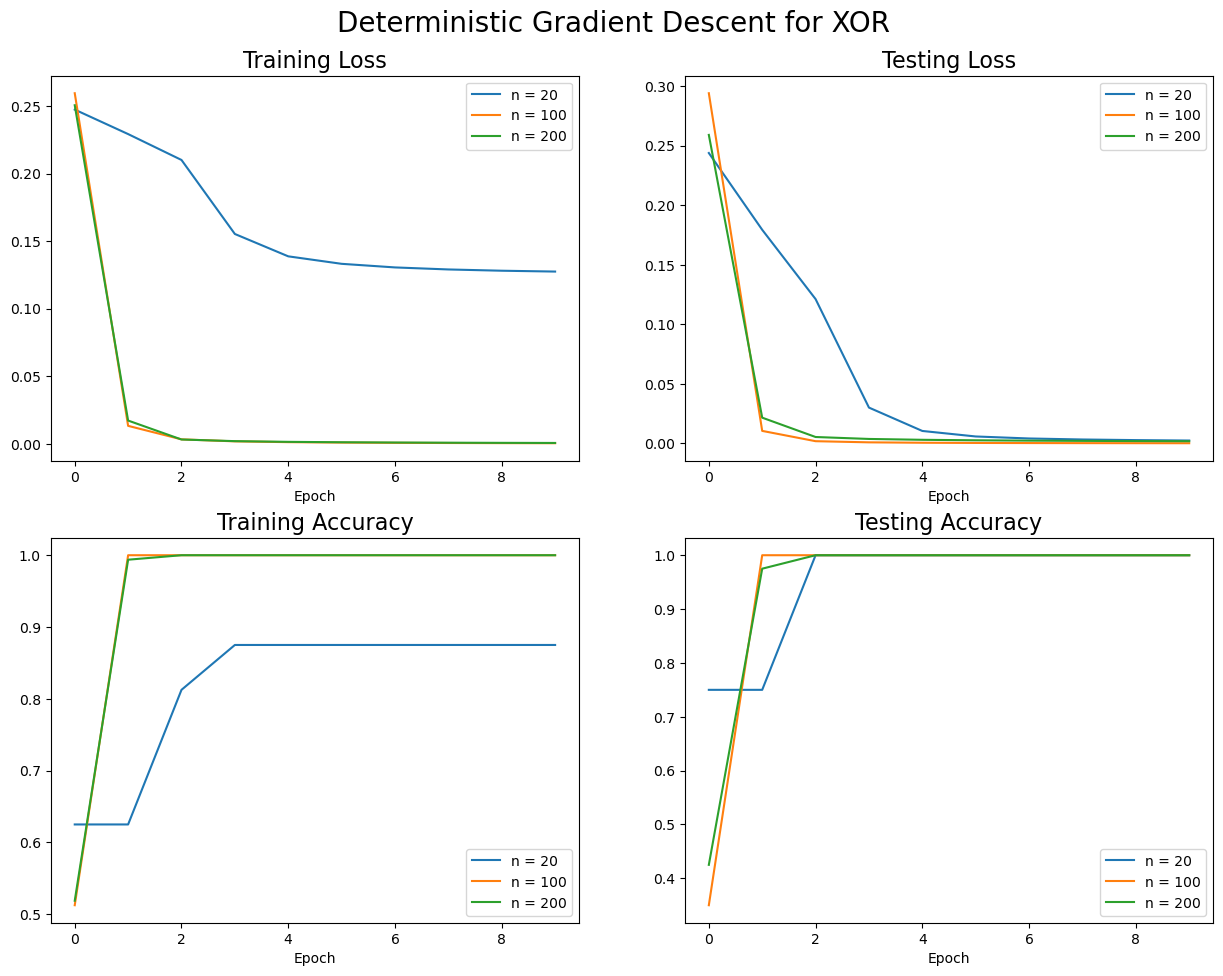

Final Training Loss for m = 1: 0.25064139
Final Testing Loss for m = 1: 0.25040811
Final Training Accuracy for m = 1: 0.50500000
Final Testing Accuracy for m = 1: 0.51000000

Final Training Loss for m = 10: 0.01847818
Final Testing Loss for m = 10: 0.01796310
Final Training Accuracy for m = 10: 0.99250000
Final Testing Accuracy for m = 10: 0.99000000

Final Training Loss for m = 100: 0.00586262
Final Testing Loss for m = 100: 0.00143818
Final Training Accuracy for m = 100: 0.99000000
Final Testing Accuracy for m = 100: 1.00000000



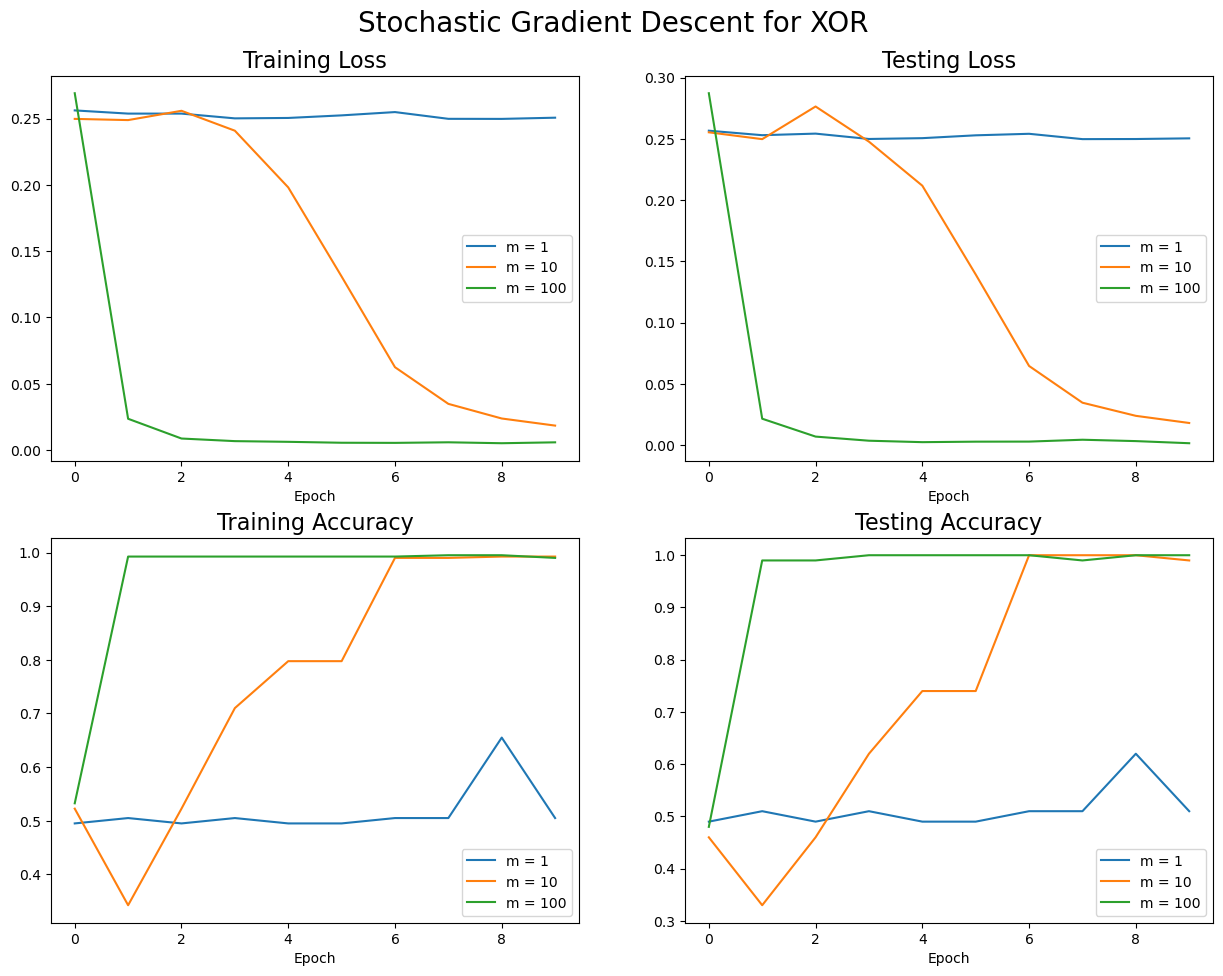

In [8]:
def XOR(x, y): 
    return x ^ y
report(XOR)

#### 2) OR

Final Training Loss for n = 20: 0.00089712
Final Testing Loss for n = 20: 0.00755919
Final Training Accuracy for n = 20: 1.00000000
Final Testing Accuracy for n = 20: 1.00000000

Final Training Loss for n = 100: 0.00017597
Final Testing Loss for n = 100: 0.00076007
Final Training Accuracy for n = 100: 1.00000000
Final Testing Accuracy for n = 100: 1.00000000

Final Training Loss for n = 200: 0.00024957
Final Testing Loss for n = 200: 0.00361518
Final Training Accuracy for n = 200: 1.00000000
Final Testing Accuracy for n = 200: 1.00000000



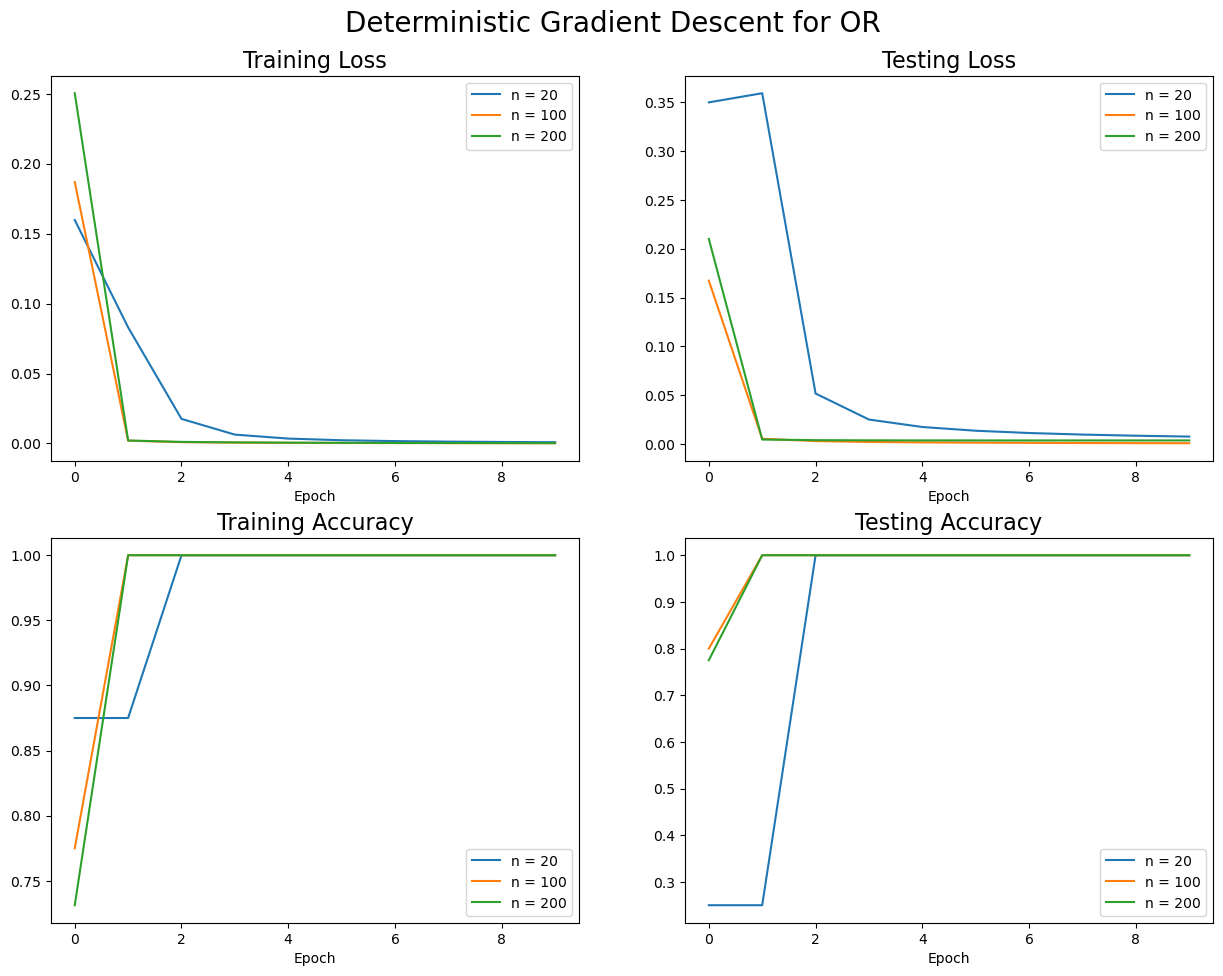

Final Training Loss for m = 1: 0.05801207
Final Testing Loss for m = 1: 0.05776144
Final Training Accuracy for m = 1: 0.97500000
Final Testing Accuracy for m = 1: 0.96000000

Final Training Loss for m = 10: 0.01057755
Final Testing Loss for m = 10: 0.00344149
Final Training Accuracy for m = 10: 0.98750000
Final Testing Accuracy for m = 10: 1.00000000

Final Training Loss for m = 100: 0.00052288
Final Testing Loss for m = 100: 0.00652020
Final Training Accuracy for m = 100: 1.00000000
Final Testing Accuracy for m = 100: 0.99000000



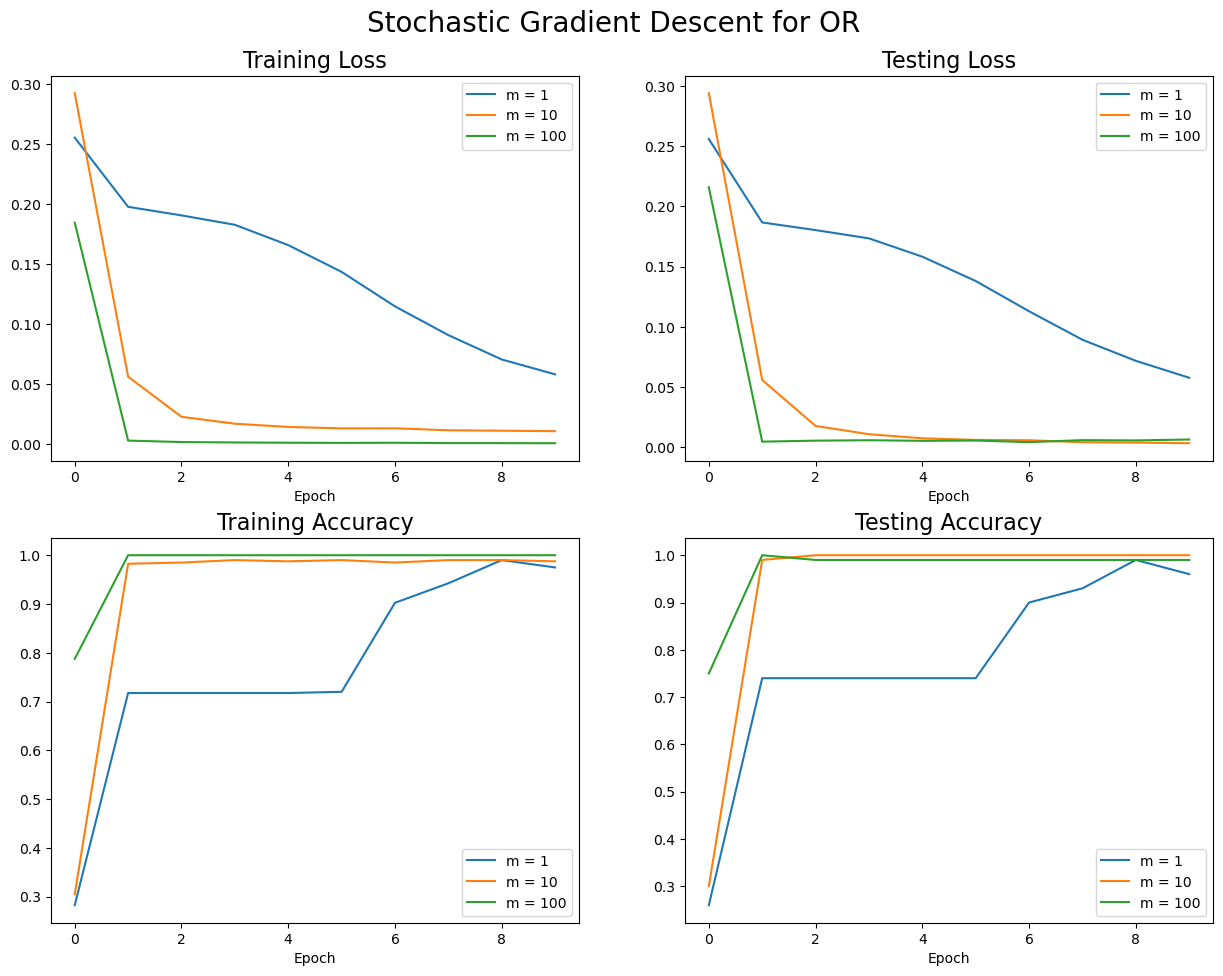

In [9]:
def OR(x, y): 
	return x | y
report(OR)

#### 3) AND

Final Training Loss for n = 20: 0.00111952
Final Testing Loss for n = 20: 0.00000707
Final Training Accuracy for n = 20: 1.00000000
Final Testing Accuracy for n = 20: 1.00000000

Final Training Loss for n = 100: 0.00046945
Final Testing Loss for n = 100: 0.00011605
Final Training Accuracy for n = 100: 1.00000000
Final Testing Accuracy for n = 100: 1.00000000

Final Training Loss for n = 200: 0.00018559
Final Testing Loss for n = 200: 0.00007240
Final Training Accuracy for n = 200: 1.00000000
Final Testing Accuracy for n = 200: 1.00000000



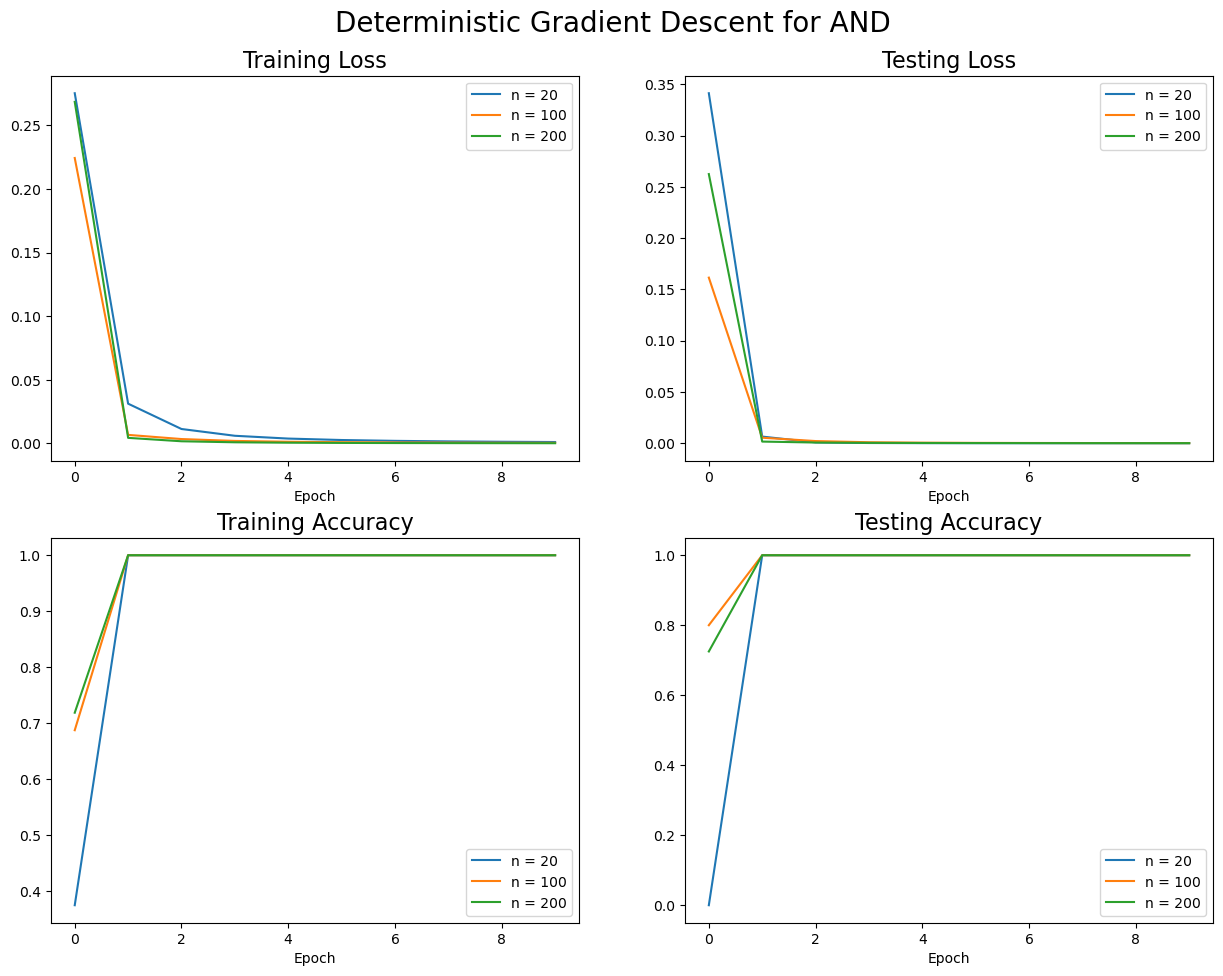

Final Training Loss for m = 1: 0.11085393
Final Testing Loss for m = 1: 0.10757666
Final Training Accuracy for m = 1: 0.79500000
Final Testing Accuracy for m = 1: 0.82000000

Final Training Loss for m = 10: 0.00416958
Final Testing Loss for m = 10: 0.00167433
Final Training Accuracy for m = 10: 0.99750000
Final Testing Accuracy for m = 10: 1.00000000

Final Training Loss for m = 100: 0.00037352
Final Testing Loss for m = 100: 0.00015254
Final Training Accuracy for m = 100: 1.00000000
Final Testing Accuracy for m = 100: 1.00000000



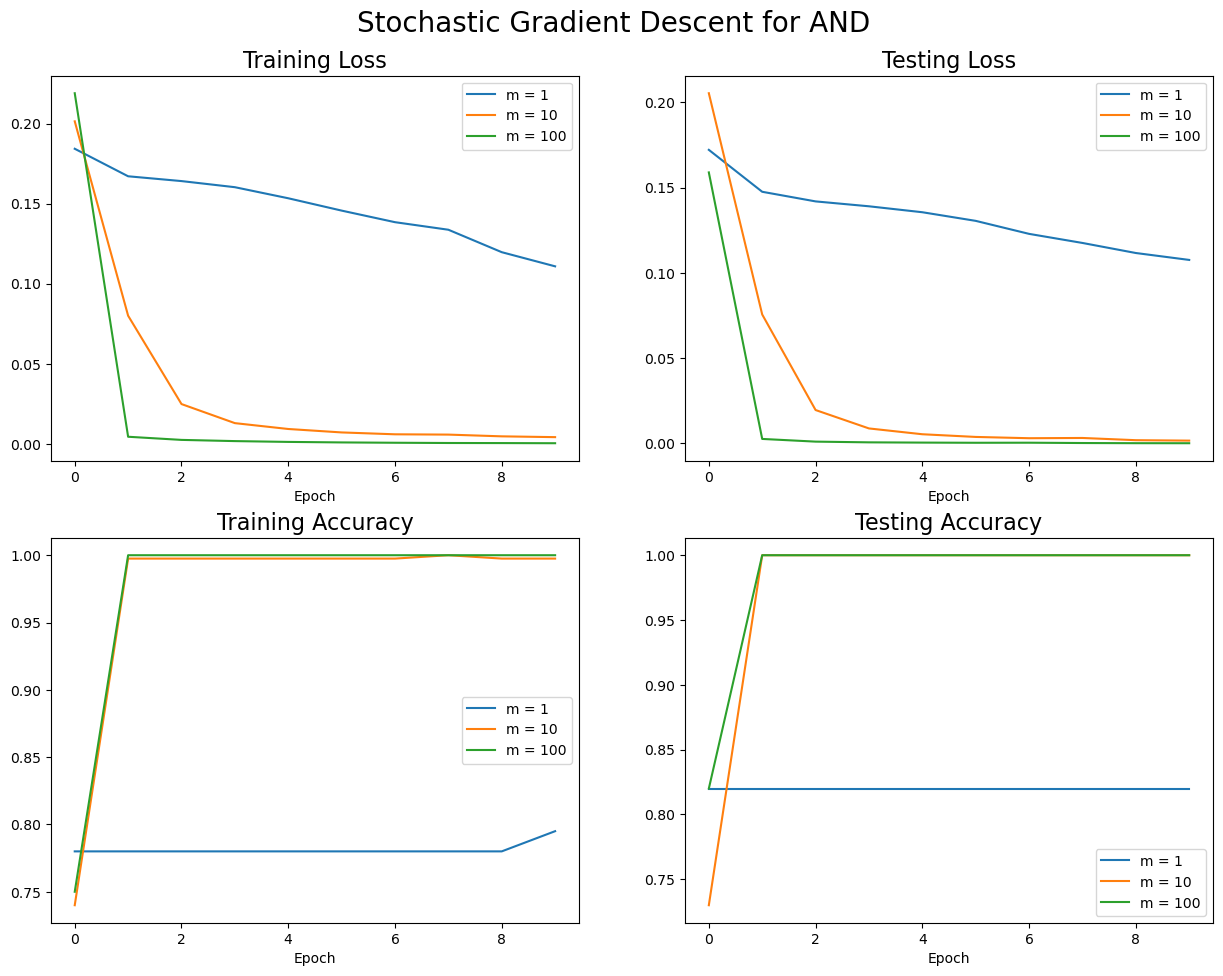

In [10]:
def AND(x, y): 
	return x & y
report(AND)

#### 4) Bonus

#### Sin x

Epoch: 1 | Training Loss: 415.43444222803953 | Testing Loss: 109.96903589198047 | Training Accuracy: 45.56625 | Testing Accuracy: 8.93
Epoch: 201 | Training Loss: 661.3749542798795 | Testing Loss: 170.81572315944922 | Training Accuracy: 53.075 | Testing Accuracy: 14.2
Epoch: 401 | Training Loss: 694.3232540286955 | Testing Loss: 178.9710292366544 | Training Accuracy: 54.67375 | Testing Accuracy: 14.85
Epoch: 601 | Training Loss: 721.1862295696925 | Testing Loss: 184.9924694791442 | Training Accuracy: 60.495 | Testing Accuracy: 17.08


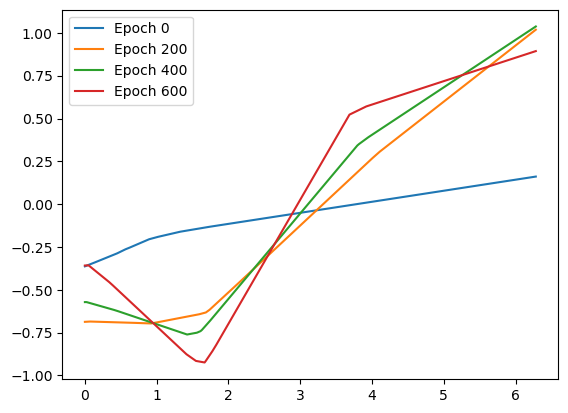

In [11]:
import math

X = np.random.rand(1000) * math.pi * 2
Y = -np.sin(X)

X_train, X_test, Y_train, Y_test = X[:800], X[800:], Y[:800], Y[800:]

# Train the model
sinx_ann = ANN(layers_nodes = [1, 10, 10, 1], layers_activations=[ReLU, ReLU, identity], gk=identity, loss=squared_error_loss, bias=True)
sinx_ann.train_SGD(X_train, Y_train, X_test, Y_test, learning_rate=0.0002, max_epochs=601, batch_size=400, convergence_threshold=0, verbose=2, accuracy_threshold=0.08, losses=True)
plt.legend()
plt.show()

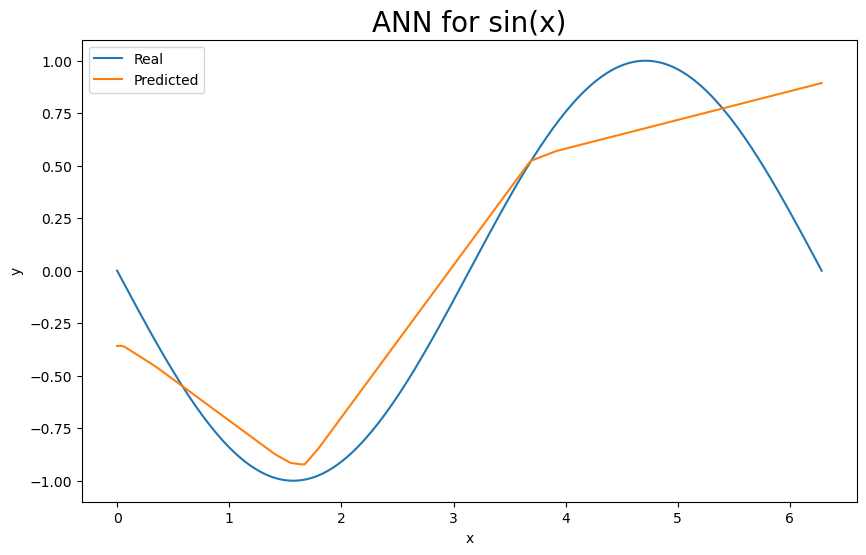

ANN with 1 input nodes, 1 output nodes and 2 ([10, 10] nodes) hidden layers

Layer 1: Layer(n_inputs=2, n_neurons=10, activation=ReLU, bias=True) 
	Weights:
[[-0.00006 -0.47477 -0.34243  0.10395 -0.33067 -0.3895  -0.91285 -0.44887
  -0.47952 -0.02899]
 [-0.20177  0.26419 -0.16761 -0.33229 -0.08941 -0.16508  0.54677 -0.13005
  -0.40463  0.56833]]
Layer 2: Layer(n_inputs=11, n_neurons=10, activation=ReLU, bias=True) 
	Weights:
[[-0.03754  0.42629 -0.44055 -0.0565   0.25852 -0.20648  0.34408 -0.34719
   0.48248  0.72822]
 [ 0.44177 -0.04597  0.13923  0.47946 -0.1793   0.16506  0.49209  0.24962
   0.47881  0.48798]
 [ 0.33097 -0.47332 -0.18516 -0.38584 -0.13758 -0.16494 -0.35606 -0.02868
  -0.43444 -0.26628]
 [-0.3042   0.00525 -0.03842  0.2494  -0.47694  0.4246   0.06796 -0.1424
  -0.1561  -0.38053]
 [ 0.22564 -0.04962  0.31116  0.2341   0.29763  0.04574 -0.30805  0.06224
  -0.04716  0.1501 ]
 [ 0.18256  0.4022   0.36531 -0.29797 -0.41942 -0.00888  0.05428 -0.49077
   0.08312 -0.33582]
 [

In [12]:
# Plot the model predictions
X_plot = np.linspace(0, 2*math.pi, 200)
Y_real = -np.sin(X_plot)
Y_pred = sinx_ann.predict(X_plot)
plt.figure(figsize=(10, 6))
plt.plot(X_plot, Y_real, label='Real')
plt.plot(X_plot, Y_pred, label='Predicted')
plt.title('ANN for sin(x)', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

print(sinx_ann)

#### MNIST

In [13]:
# Import libraries
from keras.datasets import mnist
from keras.utils import to_categorical

2023-11-09 04:17:10.876340: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-09 04:17:11.115163: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 04:17:11.115201: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 04:17:11.116572: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 04:17:11.255505: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-09 04:17:11.257419: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

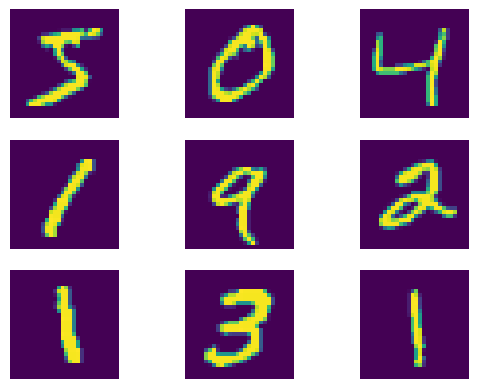

In [14]:
# Load MNIST dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
(X_train, Y_train), (X_test, Y_test) = (X_train[:6000], Y_train[:6000]), (X_test[:1000], Y_test[:1000])

fig, axs = plt.subplots(3, 3)
cnt = 0
for i in range(3):
     for j in range(3):
        axs[i, j].imshow(X_train[cnt])
        axs[i, j].axis('off')
        cnt += 1

In [15]:
# Normalize the data
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_train = X_train.astype('float32')
X_train /= 255
Y_train = to_categorical(Y_train)

X_test = X_test.reshape(X_test.shape[0], 28*28)
X_test = X_test.astype('float32')
X_test /= 255
Y_test = to_categorical(Y_test)

In [16]:
# Initialize the model
digits_ann = ANN(layers_nodes = [28*28, 100, 50, 10], layers_activations=[tanh, tanh, tanh], gk=tanh, loss=squared_error_loss, bias=True)

In [17]:
# Train the model
digits_ann.train_SGD(X_train, Y_train, X_test, Y_test, learning_rate=0.00002, max_epochs=200, batch_size=1000, convergence_threshold=0, verbose=1, accuracy_threshold=0.1)

In [18]:
digits_ann.train_SGD(X_train, Y_train, X_test, Y_test, learning_rate=0.000005, max_epochs=10, batch_size=4000, convergence_threshold=0, verbose=1, accuracy_threshold=0.1)

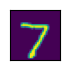

Prediction: 7 




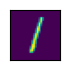

Prediction: 1 




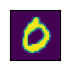

Prediction: 0 




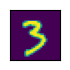

Prediction: 6 




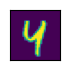

Prediction: 9 




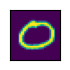

Prediction: 0 




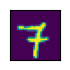

Prediction: 9 




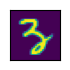

Prediction: 5 




In [19]:
test_indices = [0, 2, 3, 30, 42, 69, 75, 87]
for index in test_indices:
    # display the image
	plt.figure(figsize=(0.8, 0.8))
	plt.imshow(X_test[index].reshape(28, 28))
	plt.xticks([])
	plt.yticks([])
	plt.tight_layout()
	plt.show()
	print(f'Prediction: {np.argmax(digits_ann.predict(X_test[index].reshape(1, -1)))} \n\n')